In [1]:
from random import randint
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import accuracy_score # for calculating accuracy of model
import math
import matplotlib.pyplot as plt
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.indicators.hv import HV
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Flatten

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

# MNIST

In [105]:
(x_train_m, y_train_m), (x_test_m, y_test_m) = mnist.load_data()
x_train_m, x_test_m = x_train_m / 255.0, x_test_m / 255.0

In [106]:
x_train_m.shape

(60000, 28, 28)

In [107]:
x_test_m.shape

(10000, 28, 28)

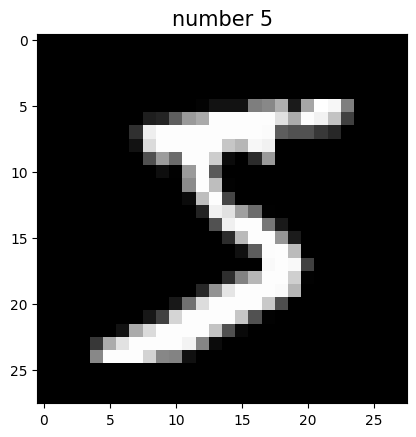

In [157]:
plt.imshow(x_train_m[0], cmap = 'gray')
plt.title(f'number {y_train_m[0]}', size = 15)
plt.show()

## Sampling from the data

In [108]:
train_diversity_m = pd.DataFrame(y_train_m[:5000], columns = ['class'])

In [109]:
train_diversity_m['class'].value_counts()

1    563
7    550
4    535
6    501
9    495
3    493
2    488
0    479
8    462
5    434
Name: class, dtype: int64

In [110]:
test_diversity_m = pd.DataFrame(y_test_m[:2000], columns = ['class'])
test_diversity_m['class'].value_counts()

1    234
2    219
4    217
3    207
7    205
9    194
8    192
5    179
6    178
0    175
Name: class, dtype: int64

# CNN Architecture in order to get embeddings

Inspiration for picking the neural net's architecture to get the embeddings:

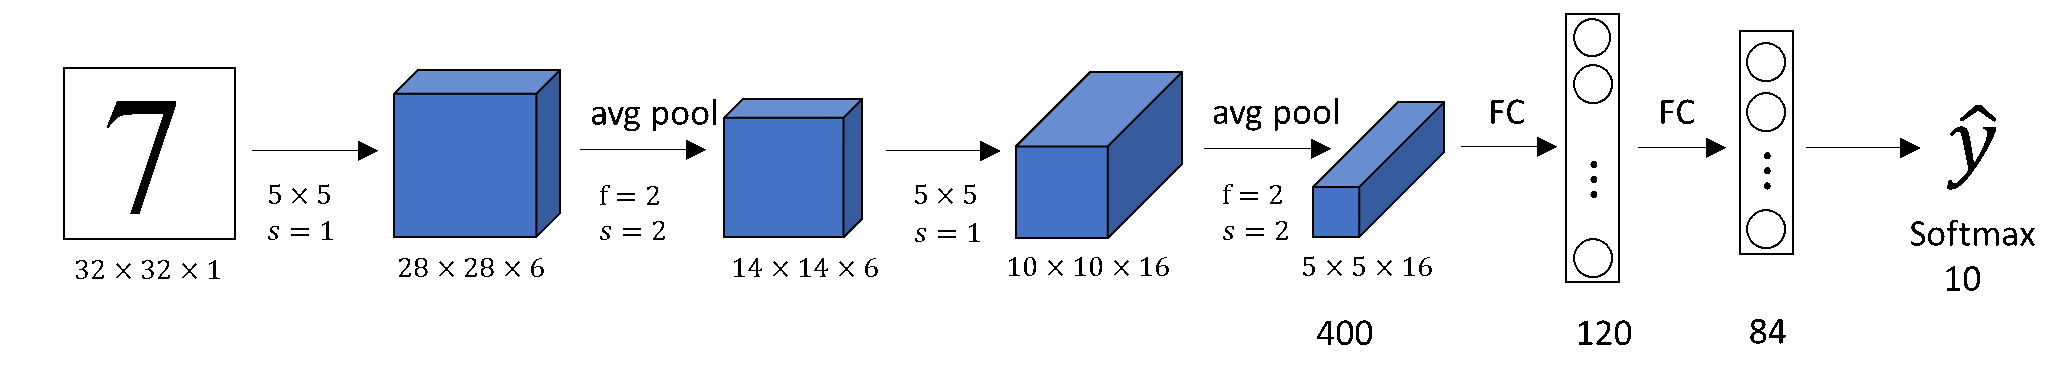

In [111]:
input_ = Input(shape=(28, 28, 1))
x = Conv2D(16, 3, activation='relu', padding='same')(input_)
x = MaxPool2D(2)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = MaxPool2D(2)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(160, activation='relu')(x)
x = Dense(84, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
mnist_model = Model(input_, output)
mnist_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 7, 64)          1849

In [112]:
mnist_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [113]:
mnist_model.fit(x_train_m, y_train_m, epochs=10, verbose = 1, batch_size = 20)

Epoch 1/10
3000/3000 [==============================] - 65s 15ms/step - loss: 0.1433 - accuracy: 0.9550
Epoch 2/10
3000/3000 [==============================] - 47s 16ms/step - loss: 0.0490 - accuracy: 0.9847
Epoch 3/10
3000/3000 [==============================] - 48s 16ms/step - loss: 0.0366 - accuracy: 0.9889
Epoch 4/10
3000/3000 [==============================] - 47s 16ms/step - loss: 0.0274 - accuracy: 0.9919
Epoch 5/10
3000/3000 [==============================] - 49s 16ms/step - loss: 0.0228 - accuracy: 0.9930
Epoch 6/10
3000/3000 [==============================] - 52s 17ms/step - loss: 0.0198 - accuracy: 0.9940
Epoch 7/10
3000/3000 [==============================] - 47s 16ms/step - loss: 0.0162 - accuracy: 0.9949
Epoch 8/10
3000/3000 [==============================] - 48s 16ms/step - loss: 0.0153 - accuracy: 0.9956
Epoch 9/10
3000/3000 [==============================] - 48s 16ms/step - loss: 0.0139 - accuracy: 0.9959
Epoch 10/10
3000/3000 [==============================] - 47s 16m

In [114]:
mnist_model.evaluate(x_test_m, y_test_m)

313/313 [==============================] - 2s 7ms/step - loss: 0.0324 - accuracy: 0.9915


[0.03244533762335777, 0.9915000200271606]

### Saving the model

In [116]:
mnist_model.save(filepath = "mnist_model.keras")

### Reloading the model without softmax (classification) layer

In [117]:
original_model = tf.keras.models.load_model('mnist_model.keras')

In [118]:
original_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 7, 64)          1849

In [119]:
shared_layers = tf.keras.models.Sequential([layer for layer in original_model.layers
                                            if layer not in [original_model.layers[-2],
                                         original_model.layers[-1]]])

In [120]:
shared_layers.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 3, 3, 64)         

In [121]:
embedding_model = tf.keras.models.Model(shared_layers.input, Dense(84)(shared_layers.output))

In [122]:
for layer in embedding_model.layers:
	layer.trainable = False

In [123]:
embedding_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 7, 64)          1849

## data preparing for feature selection

In [124]:
x_train_m, y_train_m = x_train_m[:5000], y_train_m[:5000]
x_test_m, y_test_m = x_test_m[:2000], y_test_m[:2000]

In [125]:
x_train_m.shape, x_test_m.shape

((5000, 28, 28), (2000, 28, 28))

In [126]:
y_train_m.shape, y_test_m.shape

((5000,), (2000,))

In [127]:
embedded_images_train = embedding_model(x_train_m)

In [129]:
embedded_images_train.shape

TensorShape([5000, 84])

In [130]:
embedded_images_test = embedding_model(x_test_m)

In [131]:
embedded_images_test.shape

TensorShape([2000, 84])

In [132]:
# Create a DataFrame with the training data
mnist_train = pd.DataFrame(data = embedded_images_train, columns = [str(i) for i in range(84)])

# Create a DataFrame with the testing data
mnist_test = pd.DataFrame(data = embedded_images_test, columns = [str(i) for i in range(84)])

# Concatenate the training and testing DataFrames
mnist_data = pd.concat([mnist_train, mnist_test], ignore_index=True)
mnist_data.reset_index(inplace = True, drop = True)
# Display the resulting DataFrame
mnist_data

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,-0.891805,0.482379,1.831038,3.128067,-3.168616,0.310158,-1.952626,1.408112,0.856157,-3.261988,...,1.124495,0.089439,-0.813774,0.970476,-3.710133,-0.107478,1.030414,-0.694913,-0.462161,-2.371972
1,0.523846,-2.436496,0.694970,1.256591,-0.803966,-0.388208,-3.886358,2.538142,0.940025,0.783733,...,-0.718171,-1.134109,-0.760270,-0.829913,-0.004677,1.291276,-0.194492,1.479330,1.490711,-0.653939
2,0.867113,-0.780461,-0.022531,3.760440,-1.605006,0.484115,-3.771678,-3.060952,0.465825,-2.575496,...,-0.524888,0.374016,0.712460,0.325882,2.290784,1.080653,1.201184,0.869019,-1.087664,4.912929
3,-0.027450,0.301518,-0.445514,-0.159057,0.588068,0.558247,-0.060621,0.357667,-0.507944,-2.219606,...,-1.209501,0.618653,-0.189104,-0.441354,-0.530407,-0.132526,-0.158984,0.183936,-0.681104,0.046986
4,0.011452,-0.804941,0.630992,-0.707510,-0.410322,0.248321,-1.076778,-0.714587,-1.575766,-0.605407,...,-0.871581,1.056443,-0.249168,0.110555,2.457627,-0.606718,-1.531165,0.268448,-1.406549,1.613683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,1.414796,-2.320445,0.242451,2.103952,0.002548,-0.686958,-3.197284,1.487642,0.351295,0.476450,...,0.029691,-1.280335,-0.776648,-0.931581,-0.579349,0.037480,-0.805631,0.681172,1.715361,-0.462475
6996,0.907146,-0.725298,-0.400692,0.198659,-1.384743,-1.847471,-4.485352,-0.273968,-0.550772,-1.700018,...,-1.452736,-2.734696,-2.665132,-1.067092,-1.404757,1.712034,0.687525,-0.330435,-2.821778,2.167486
6997,1.061581,-0.562993,0.837881,-0.722836,0.083442,0.244304,-1.505105,0.013059,0.400589,-1.741516,...,2.188265,-1.066859,-0.939436,2.318838,-0.054961,1.418116,-1.715456,1.834245,0.997585,0.433014
6998,0.259761,-0.787066,0.451722,-0.430294,0.238930,-0.025186,-0.462673,-0.530236,-1.532721,-0.234053,...,-0.449566,0.517703,0.461223,-0.938362,1.513060,-0.220509,-1.169215,0.466416,-0.935685,2.223972


In [134]:
mnist_label = np.concatenate([y_train_m, y_test_m])
mnist_label = pd.DataFrame(data = mnist_label, columns = ['class'])
scaler = MinMaxScaler()
scaler.fit(mnist_data)
mnist_data = pd.DataFrame(scaler.transform(mnist_data), columns = mnist_data.columns)
xtrain, xtest, ytrain, ytest = train_test_split(mnist_data, mnist_label, test_size=2/7, stratify=mnist_label)

In [135]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((5000, 84), (2000, 84), (5000, 1), (2000, 1))

In [136]:
mnist_data

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.389386,0.606973,0.574879,0.760761,0.365912,0.459758,0.559360,0.617681,0.696560,0.315163,...,0.755896,0.653547,0.565750,0.560491,0.208358,0.371081,0.695649,0.340697,0.518801,0.166556
1,0.578108,0.283798,0.434944,0.554021,0.629448,0.347773,0.301177,0.728688,0.711621,0.841781,...,0.582515,0.458192,0.573475,0.324797,0.549649,0.553725,0.477841,0.628842,0.754442,0.299828
2,0.623869,0.467152,0.346565,0.830619,0.540174,0.487653,0.316489,0.178669,0.626462,0.404522,...,0.600702,0.698983,0.786119,0.476106,0.761072,0.526223,0.726015,0.547960,0.443326,0.731664
3,0.504614,0.586948,0.294464,0.397635,0.784589,0.499540,0.811971,0.514492,0.451586,0.450847,...,0.536285,0.738042,0.655944,0.375664,0.501226,0.367810,0.484155,0.457168,0.492383,0.354201
4,0.509800,0.464442,0.427063,0.337048,0.673319,0.449842,0.676299,0.409161,0.259821,0.660962,...,0.568080,0.807941,0.647272,0.447916,0.776439,0.305892,0.240158,0.468368,0.404848,0.475733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.696882,0.296647,0.379205,0.647628,0.719333,0.299867,0.393179,0.625494,0.605894,0.801784,...,0.652883,0.434846,0.571110,0.311487,0.496719,0.390009,0.369170,0.523065,0.781549,0.314681
6996,0.629206,0.473260,0.299985,0.437152,0.564722,0.113775,0.221202,0.452444,0.443895,0.518480,...,0.513398,0.202639,0.298437,0.293747,0.420695,0.608666,0.634678,0.389000,0.234081,0.518693
6997,0.649794,0.491230,0.452547,0.335355,0.728349,0.449198,0.619110,0.480640,0.614746,0.513078,...,0.855988,0.468930,0.547606,0.737010,0.545017,0.570288,0.207389,0.675878,0.694940,0.384146
6998,0.542903,0.466421,0.404981,0.367672,0.745678,0.405985,0.758291,0.427270,0.267551,0.709300,...,0.607789,0.721924,0.749843,0.310599,0.689440,0.356322,0.304519,0.494604,0.461664,0.523075


# Running the NSGA-2 Algorithm

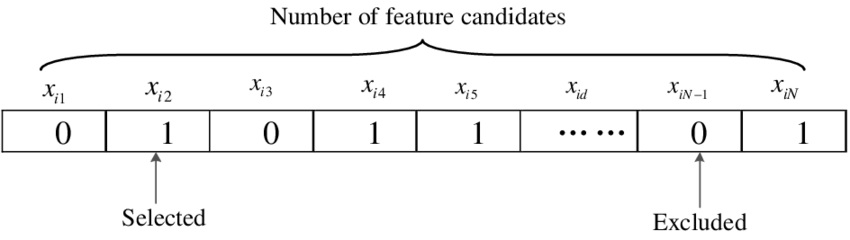

In [139]:
class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=84, # decision variables
                         n_obj=2, # two objective functions
                         n_ieq_constr=1)

    def __classification_error__(self,bitstring):
        featureNames = []
        for i in range(len(bitstring)):
            if bitstring[i] == 1:
                featureNames.append(mnist_data.columns[i])

        if len(featureNames) == 0:
            return 1
        trainx = pd.DataFrame(xtrain[featureNames])
        trainy = ytrain
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(trainx, trainy.values.ravel())
        predy = knn.predict(trainx)
        ac = accuracy_score(trainy, predy)
        return 1 - ac

    def __fetures_number__(self,bitstring):
        return sum(bitstring)

    def __constrain__(self,bitstring):
        return 1 - sum(bitstring)

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = [self.__fetures_number__(x[i]) for i in range(0, len(x))]
        f2 = [self.__classification_error__(x[i]) for i in range(0, len(x))]
        g1 = [self.__constrain__(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])

In [140]:
f_list = []
pop_list = []
x_list = []
i_f_list = []
i_pop_list = []

    
xtrain, xtest, ytrain, ytest = train_test_split(mnist_data, mnist_label, test_size=2/7, stratify=mnist_label)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(xtrain, ytrain.values.ravel())
ypred = knn.predict(xtrain)
ac = accuracy_score(ytrain, ypred)
print("Classification error on training sets using all features: " + str(1 - ac))
ypred = knn.predict(xtest)
ac = accuracy_score(ytest, ypred)
print("Classification error on testing sets using all features: " + str(1 - ac))

print("###################################################################################")
problem = MyProblem()

algorithm = NSGA2(pop_size=100,
                  sampling=BinaryRandomSampling(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ("n_gen", 100),
               verbose=False,
               save_history=True)
i_f = res.history[0].opt.get("F")
i_pop = res.history[0].pop
f = res.F
pop = res.pop
solutions = res.X

Classification error on training sets using all features: 0.005199999999999982
Classification error on testing sets using all features: 0.005499999999999949
###################################################################################


# Initial and Final Pareto Front

the intial pareto front is plotted as: 


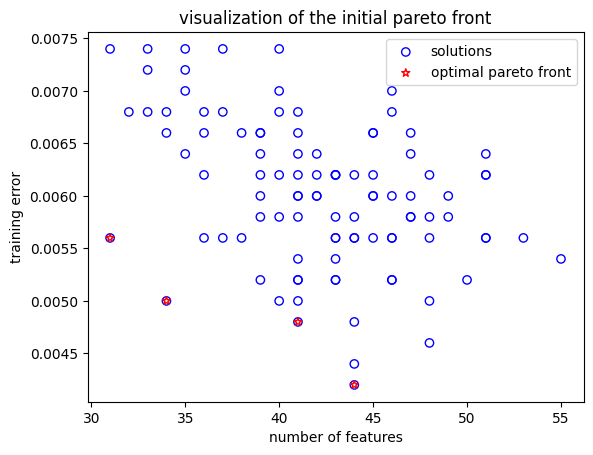

the final pareto front is plotted as: 


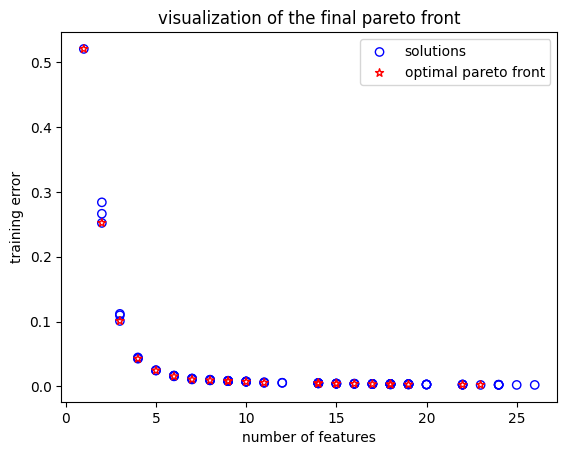

In [142]:
print("the intial pareto front is plotted as: ")
plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the initial pareto front")
plt.show()
print("the final pareto front is plotted as: ")
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the final pareto front")
plt.show()

# Performance on training set - selected features

In [145]:
mce_on_train_solution_tnr = []
mce_on_train_tnr = 10
mce_on_test_tnr = 10
mce_on_test_solution_ttr = []
mce_on_test_ttr = 10
mce_on_train_ttr = 10

print("evaluation of the solutions on the final pareto front")
for s in range(len(solutions)):
    solution = solutions[s]
    # print("solution " + str(s) + " with a vector " + str(np.multiply(solution, 1)) + ":")
    print("solution " + str(s) + ":")
    print("number of selected features is: " + str(f[:,0][s]) + " out of 100")
    indices = [i + 1 for i, x in enumerate(np.multiply(solution, 1)) if x == 1]
    print("corresponding indices: " + str(indices))
    print("classification error on train sets: " + str(f[:, 1][s]))
    featureNames = []
    for i in range(len(solution)):
        if solution[i] == 1:
            featureNames.append(mnist_data.columns[i])
    trainx = pd.DataFrame(xtrain[featureNames])
    testx = pd.DataFrame(xtest[featureNames])
    trainy = ytrain
    testy = ytest
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(trainx, trainy.values.ravel())
    predy = knn.predict(testx)
    ac = accuracy_score(testy, predy)
    mce = 1-ac
    if f[:, 1][s] < mce_on_train_tnr:
        mce_on_train_tnr = f[:, 1][s]
        mce_on_test_tnr = mce
        mce_on_train_solution_tnr = np.multiply(solution, 1)
    if mce < mce_on_test_ttr:
        mce_on_test_ttr = mce
        mce_on_train_ttr = f[:, 1][s]
        mce_on_test_solution_ttr = np.multiply(solution, 1)
    print("classification error on test sets: " + str(mce))
print("##################################################################################################")

evaluation of the solutions on the final pareto front
solution 0:
number of selected features is: 1.0 out of 100
corresponding indices: [28]
classification error on train sets: 0.5204
classification error on test sets: 0.7344999999999999
solution 1:
number of selected features is: 5.0 out of 100
corresponding indices: [9, 28, 39, 79, 80]
classification error on train sets: 0.024399999999999977
classification error on test sets: 0.03500000000000003
solution 2:
number of selected features is: 2.0 out of 100
corresponding indices: [28, 39]
classification error on train sets: 0.252
classification error on test sets: 0.35350000000000004
solution 3:
number of selected features is: 3.0 out of 100
corresponding indices: [28, 39, 79]
classification error on train sets: 0.1008
classification error on test sets: 0.12949999999999995
solution 4:
number of selected features is: 18.0 out of 100
corresponding indices: [8, 9, 16, 20, 21, 27, 28, 29, 39, 42, 44, 49, 54, 66, 76, 79, 80, 83]
classificatio

In [146]:
print("details of best solution (with minimum classification error) on traning set: ")
indices = [i + 1 for i, x in enumerate(mce_on_train_solution_tnr) if x == 1]
print("corresponding indices: " + 
      str(indices))
print("number of selected features: " + str(sum(mce_on_train_solution_tnr)))
print("error rate on training set: " + str(mce_on_train_tnr))
print("error rate on testing set: " + str(mce_on_test_tnr))

details of best solution (with minimum classification error) on traning set: 
corresponding indices: [8, 9, 16, 20, 21, 27, 28, 29, 30, 39, 42, 43, 44, 49, 54, 66, 69, 73, 75, 76, 79, 80, 83]
number of selected features: 23
error rate on training set: 0.0021999999999999797
error rate on testing set: 0.008499999999999952


 # Performance on testing set - selected features

In [147]:
print("details of best solution (with minimum classification error) on testing set: ")
indices = [i + 1 for i, x in enumerate(mce_on_test_solution_ttr) if x == 1]
print("corresponding indices: " + 
      str(indices))
print("number of selected features: " + str(sum(mce_on_test_solution_ttr)))
print("error rate on training set: " + str(mce_on_train_ttr))
print("error rate on testing set: " + str(mce_on_test_ttr))

details of best solution (with minimum classification error) on testing set: 
corresponding indices: [9, 14, 28, 30, 31, 51, 57, 71, 79, 80]
number of selected features: 10
error rate on training set: 0.007000000000000006
error rate on testing set: 0.00649999999999995


# Hypervolume : performance indicator quality of paretofront approximation

The Hypervolume indicator measures the volume of the objective space that is dominated by a set of solutions. It represents how well a set of solutions covers the objective space and is often used to compare different Pareto front approximations. A higher Hypervolume value indicates a better approximation to the true Pareto front.

# HV

In [148]:
ref_point = np.array([1, 1])
ind = HV(ref_point=ref_point)
scaler = MinMaxScaler()
f = scaler.fit_transform(f)
hv = ind(f)
print("HV of the best pareto front:" + str(round(hv, 2)))

HV of the best pareto front:0.91
